In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
import interpolation
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [2]:
# I plan to move this into a file
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
census_1880.dropna(subset = ["block_num"], inplace = True)
census_1880.reset_index(inplace = True)
filled_1850.dropna(subset = ["CENSUS_DWELLING_NUM"], inplace = True)
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num"}, inplace = True)

In [4]:
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [5]:
# dwellings_1850 = filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
# dwellings_1880 = census_1880.drop_duplicates(subset = ["CENSUS_ADDRESS"]).copy()

In [6]:
# interpolation.col_for_seq(dwellings_1850, "CD_X", "CD_Y", Address = None, Ward = None)
# interpolation.col_for_seq(dwellings_1880, "POINT_X", "POINT_Y", Address = None, Ward = None)
# dwellings_1850 = interpolation.get_dist_seq(dwellings_1850, 0.15)[2]
# dwellings_1880 = interpolation.get_dist_seq(dwellings_1880, 0.15)[2]
# dwellings_1850.groupby("sequence_id").apply(interpolation.sequence_order)
# dwellings_1880.groupby("sequence_id").apply(interpolation.sequence_order)
# census_1880_model = interpolation.dwellings_to_all(census_1880, dwellings_1880, ["CENSUS_MATCH_ADDR", "sequence_id", "sequence_order"], ["CENSUS_MATCH_ADDR"])
# census_1850_model = interpolation.dwellings_to_all(filled_1850, dwellings_1850, ["WARD_NUM", "CENSUS_DWELLING_NUM","sequence_id", "sequence_order"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
# interpolation.create_street_house(census_1880_model, "CENSUS_ADDRESS")
# interpolation.create_street_house(census_1850_model, "CD_ADDRESS")

In [7]:
cols = ["street_name", "sequence_id", "sequence_order", "WARD_NUM", "CENSUS_SERIALB", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_model, census_1850_model, cols)

In [8]:
X_train_te = TargetEncoder(cols = cols).fit_transform(train_X, train_y)
test_1880_X_te = TargetEncoder(cols = cols).fit_transform(test_1880_X, test_1880_y)
test_1850_X_te = TargetEncoder(cols = cols).fit_transform(test_1850_X, test_1850_y)

In [9]:
xgb = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 1000, colsample_bytree = 0.5, alpha = 1)
xgb.fit(X_train_te, train_y)
print("Training Score:", xgb.score(X_train_te, train_y))
print("1880 Test Score:", xgb.score(test_1880_X_te, test_1880_y))
print("1850 Test Score:", xgb.score(test_1850_X_te, test_1850_y))

Training Score: 0.9934638797342671
1880 Test Score: 0.9167232279683597
1850 Test Score: 0.7767870024510886


In [16]:
# Let's try with just training with just 1850 data
te = TargetEncoder(cols = cols)
train_X_1850, test_X_1850, train_y_1850, test_y_1850 = train_test_split(census_1850_model.dropna(subset = ["house_number"]).loc[:,cols], census_1850_model.dropna(subset = ["house_number"]).loc[:,"house_number"])
train_X_1850_te = te.fit_transform(train_X_1850, train_y_1850)
test_X_1850_te = te.fit_transform(test_X_1850, test_y_1850)

In [11]:
xgb = XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 800, colsample_bytree = 0.6, alpha = 1.5)
xgb.fit(train_X_1850_te, train_y_1850)
print("Training Score:", xgb.score(train_X_1850_te, train_y_1850))
print("1880 Test Score:", xgb.score(test_1880_X_te, test_1880_y))
print("1850 Test Score:", xgb.score(test_X_1850_te, test_y_1850))

Training Score: 0.9908071048984792
1880 Test Score: 0.7545951231312094
1850 Test Score: 0.9141915992677216


In [12]:
#Let's try training the linear model with just the 1850 data
lin_mod = LinearRegression()
lin_mod.fit(train_X_1850_te, train_y_1850)
print("Training Score:", lin_mod.score(train_X_1850_te, train_y_1850))
print("1880 Test Score:", lin_mod.score(test_1880_X_te, test_1880_y))
print("1850 Test Score:", lin_mod.score(test_X_1850_te, test_y_1850))

Training Score: 0.9538443991579817
1880 Test Score: 0.742573406386158
1850 Test Score: 0.7939691573575683


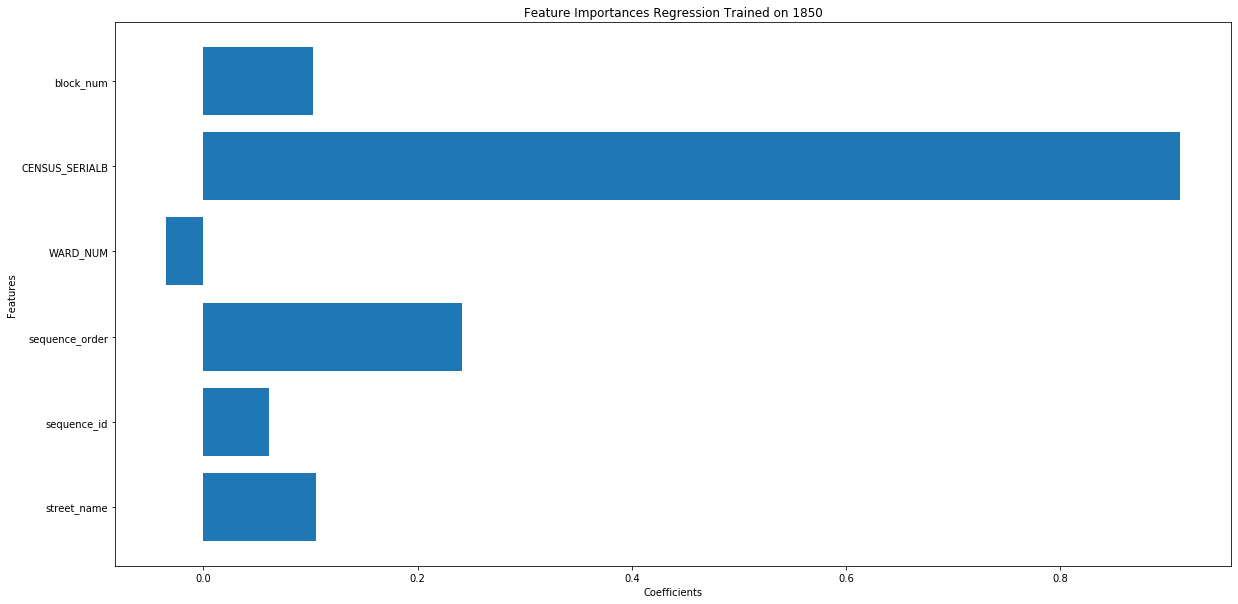

In [19]:
interpolation.graph_coefs(te.get_feature_names(), lin_mod.coef_, "Feature Importances Regression Trained on 1850")

In [13]:
lin_mod_all = LinearRegression()
lin_mod_all.fit(X_train_te, train_y)
print("Training Score:", lin_mod_all.score(X_train_te, train_y))
print("1880 Test Score:", lin_mod_all.score(test_1880_X_te, test_1880_y))
print("1850 Test Score:", lin_mod_all.score(test_1850_X_te, test_1850_y))

Training Score: 0.9667183155535946
1880 Test Score: 0.7611310380318221
1850 Test Score: 0.7530790196012122


In [14]:
### Let's try to get a sense of how well this is working
#First we need to create a set of addresses where we are reasonably sure we know the street names for

In [15]:
def comp_streets(x):
    if x["STREET_NAME"] == x["STREET_NAME_NEXT"]:
        return x["index_next"] - x["CENSUS_INDEX"]
    else:
        return None
def comp_streets_df(df):
    df["STREET_NAME_NEXT"] = df["STREET_NAME"].shift(-1)
    df["index_next"] = df["CENSUS_INDEX"].shift(-1)
    df["index_diff"] = df.apply(comp_streets, axis = 1)
    return df

In [21]:
dwellings_1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19825 entries, 0 to 19824
Data columns (total 42 columns):
WARD_NUM                   19825 non-null int64
CENSUS_DWELLING_NUM        19825 non-null float64
block_num                  7524 non-null float64
CD_ADDRESS                 7524 non-null object
CD_X                       7524 non-null float64
CD_Y                       7524 non-null float64
CENSUS_AGE                 19825 non-null int64
CENSUS_CITY                19825 non-null int64
CENSUS_DWELLING_SEQ        19812 non-null float64
CENSUS_DWELLING_SIZE       19825 non-null int64
CENSUS_GEOG                19817 non-null object
CENSUS_HH_NUM              19825 non-null int64
CENSUS_ID                  7524 non-null object
CENSUS_IMPREL              19825 non-null int64
CENSUS_INDEX               19825 non-null int64
CENSUS_IPUMS_UID           19825 non-null object
CENSUS_LABFORCE            19825 non-null int64
CENSUS_LINE                19825 non-null int64
CENSUS_MARST      